In [1]:
from bilby.core.result import read_in_result
from scipy.interpolate import interp1d
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import deepdish as dd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import h5py
import requests
import math

In [2]:
# reading in data of GWTC-3
mass_PDB_path = 'O1O2O3all_mass_h_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5'
with open(mass_PDB_path, 'r') as _data:
        _data = dd.io.load(mass_PDB_path)
        print(_data.keys())
        print(_data['lines'].keys())

dict_keys(['lines', 'ppd'])
dict_keys(['mass', 'p_mass_1', 'p_mass_2', 'pdf', 'rate_mass_1', 'rate_vs_mass'])


In [3]:
# reading in GWTC-3 data with observations untill the MGE
mass_PDB_path_2 = 'with_230529_mass_h_mass_data.h5'
with open(mass_PDB_path_2, 'r') as _data2:
        _data2 = dd.io.load(mass_PDB_path_2)
        print(_data2.keys())
        print(_data2['lines'].keys())

dict_keys(['lines', 'ppd'])
dict_keys(['mass', 'p_mass_1', 'p_mass_2', 'pdf', 'rate_mass_1', 'rate_vs_mass'])


In [4]:
# load and read file of Legred EoS Set
EOS_file = 'LCEHL_EOS_posterior_samples_PSR+GW+Nicer.h5'
EOS_set = h5py.File(EOS_file, 'r')

# we're going to do a dictionary of data frames
# the data frames contain the columns of eos or ns macroscopic values
# they have nice labels
# the dictionary labels each eos,
  # although they are sequentially numbered
  # which is why we can find them from a range of integers
baseEosSet={}
baseMacroSet={}

for i in range(len(EOS_set['ns'])):
  baseEosSet[i] = pd.DataFrame(np.array(EOS_set['eos']['eos_'+str(i)][:]))
for i in range(len(EOS_set['ns'])):
  baseMacroSet[i] = pd.DataFrame(np.array(EOS_set['ns']['eos_'+str(i)][:]))

# set a maximum mass index for the dictionaries made
maxind = [np.argmax(baseMacroSet[i]['M']) for i in baseEosSet]

In [5]:
# PDB data stores in 1500 x 2000
# each distribution is a row with each column being a mass ranging from 1-100 solar masses
# to work with NS masses, I've cut off at 2.5 solar mass for each distribution


# make list of ns masses
c_mass = _data['lines']['mass']
cut_mass = [x for x in c_mass if x <= 2.5]

# array into list
    # could have stuck with arrays
ns_masses = []
for elem in cut_mass:
    for elem2 in elem:
        ns_masses.append(elem2)
          
# define delta m as the differential
    # delta_m = mass[i+1] - mass[i]
y=1
y2=0
delta_m = []
while y<=ns_masses.index(max(ns_masses)):
    delta_m.append(ns_masses[y] - ns_masses[y2])
    y+=1
    y2+=1
    

# for MGE data
c_mass2 = _data2['lines']['mass']
cut_mass2 = [x for x in c_mass2 if x <= 2.5]

ns_masses2 = []
for elem2 in cut_mass2:
    for elem22 in elem2:
        ns_masses2.append(elem22)
          
            
y_2=1
y2_2=0
delta_m2 = []
while y_2<=ns_masses2.index(max(ns_masses2)):
    delta_m2.append(ns_masses2[y_2] - ns_masses2[y2_2])
    y_2+=1
    y2_2+=1

In [6]:
# make a function to numerically integrate differential merger rate into merger rate
# multiply the dr/dm1 value wtih corresponding delta_m 
    # can later try other integration methods
def integrate_sum(fx):
    Rates_list = []
    for x,y in zip(fx,delta_m):
        value = x * y
        Rates_list.append(value)
    # apply the sum of the products
    sum_int = sum(Rates_list)
    return sum_int

In [7]:
# for MGE data
def integrate_sum2(fx):
    Rates_list = []
    for x,y in zip(fx,delta_m2):
        value = x * y
        Rates_list.append(value)
    sum_int = sum(Rates_list)
    return sum_int

In [8]:
# numerically integrate for the 1500 rows of dr/dm1
r=0
rates = []
while r<=1499:
    rates.append(integrate_sum(_data['lines']['rate_mass_1'][r]))
    r+=1
    
# merger rate to galactic event rate
alt_rates = []
for rate in rates:
    alt_rates.append(rate*0.01)
    
# len(alt_rates)

In [9]:
# for MGE data
r2=0
rates_mge = []
while r2<=1499:
    rates_mge.append(integrate_sum2(_data2['lines']['rate_mass_1'][r2]))
    r2+=1
    
alt_rates_mge = []
for rate in rates_mge:
    alt_rates_mge.append(rate*0.01)
    
# len(alt_rates_mge)

In [10]:
# creating dictionaries of each distribution of probabilities of mass
prob_dict_mass1 = {}
prob_dict_mass2 = {}
prob_dict_mass1_mge = {}
prob_dict_mass2_mge = {}

i=0
while i<=1499:
    # probilities for each mass in the row up untill the maximum NS mass chosen(2.5)
    prob_mass1 = []
    for elem in _data['lines']['p_mass_1'][i]:
        prob_mass1.append(elem)
    prob_mass1 = prob_mass1[:ns_masses.index(max(ns_masses))+1]
    prob_dict_mass1[i] = prob_mass1
    
    prob_mass2 = []
    for elem in _data['lines']['p_mass_2'][i]:
        prob_mass2.append(elem)
    prob_mass2 = prob_mass2[:ns_masses.index(max(ns_masses))+1]
    prob_dict_mass2[i] = prob_mass2
    
    # for MGE data
    prob_mass1_mge = []
    for elem in _data2['lines']['p_mass_1'][i]:
        prob_mass1_mge.append(elem)
    prob_mass1_mge = prob_mass1_mge[:ns_masses2.index(max(ns_masses2))+1]
    prob_dict_mass1_mge[i] = prob_mass1_mge
    
    prob_mass2_mge = []
    for elem in _data2['lines']['p_mass_2'][i]:
        prob_mass2_mge.append(elem)
    prob_mass2_mge = prob_mass2_mge[:ns_masses2.index(max(ns_masses2))+1]
    prob_dict_mass2_mge[i] = prob_mass2_mge
    
    i+=1

In [11]:
# create a list of masses that'll be worked with throughought for better comparison between EoSs
list_mass1 = []
list_mass2 = []
list_mass1_mge = []
list_mass2_mge = []

j=0
while j<= 1499:
    # randomly choose a mass based on weighted probabilities
    rand_mass1 = random.choices(ns_masses, weights = prob_dict_mass1[j], cum_weights = None, k=1)
    rand_mass2 = random.choices(ns_masses, weights = prob_dict_mass2[j], cum_weights = None, k=1)
    
    # for MGE data
    rand_mass1_mge = random.choices(ns_masses2, weights = prob_dict_mass1_mge[j], cum_weights = None, k=1)
    rand_mass2_mge = random.choices(ns_masses2, weights = prob_dict_mass2_mge[j], cum_weights = None, k=1)
    
    
    # random.choices() returns list, but only the value is needed
    ns_mass1 = rand_mass1[0]
    ns_mass2 = rand_mass2[0]
    
    # for MGE data
    ns_mass1_mge = rand_mass1_mge[0]
    ns_mass2_mge = rand_mass2_mge[0]
    
    
    # redefines the mass if mass 2 is greater than mass 1
    if ns_mass1 >= ns_mass2:
        mass_1 = ns_mass1
        mass_2 = ns_mass2
    else:
        mass_2 = ns_mass1
        mass_1 = ns_mass2
        
    list_mass1.append(mass_1)
    list_mass2.append(mass_2)
        
        
    # for MGE data
    if ns_mass1_mge >= ns_mass2_mge:
        mass_1_mge = ns_mass1_mge
        mass_2_mge = ns_mass2_mge
    else:
        mass_2_mge = ns_mass1_mge
        mass_1_mge = ns_mass2_mge
        
    list_mass1_mge.append(mass_1_mge)
    list_mass2_mge.append(mass_2_mge)
        
    j+=1

Text(0, 0.5, '$m_{ej}\\ (M_{\\odot})$')

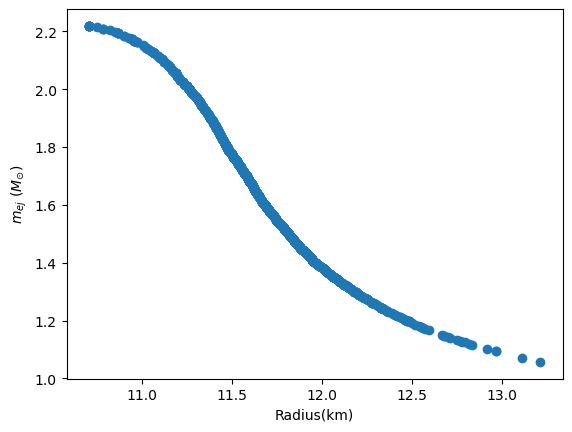

In [12]:
# testing if interpolation works with a single EoS
test_key = np.random.choice(range(len(baseMacroSet)))

test_interp_rad = interp1d(baseMacroSet[test_key]['M'][0:maxind[test_key]], baseMacroSet[test_key]['R'][0:maxind[test_key]], fill_value=np.nan, bounds_error = False)

test_rad = test_interp_rad(list_mass1)

plt.scatter(test_rad, list_mass1)
plt.xlabel('Radius(km)')
plt.ylabel('$m_{ej}\ (M_{\\odot})$')

In [13]:
# define constants
c = 2.99792e8

a1 = -8.1324
c1 = 1.4820
d = 1.7784
G = 6.67430e-11

a2 = -9.3335
b = 114.17
c2 = -337.56
n = 1.5465

In [14]:
# obtian ejected mass
M_ej = []

# when interpolating the radius, there will be NaN values because of contraints on EoSs
    # keep track of the index of NaN value as to exlude their corresponding rate
    # also avoids NaN value error when plotting
nan_rate_ind = []

# for loop to keep track of the index
for l, (m1, m2) in enumerate(zip(list_mass1, list_mass2)):
    # choose a random Eos  
    key = np.random.choice(range(len(baseMacroSet)))
    
    # interpolate the correspodning radius for each NS
    interp_rad = interp1d(baseMacroSet[key]['M'][0:maxind[key]], baseMacroSet[key]['R'][0:maxind[key]], fill_value=np.nan, bounds_error = False)
    
    Rad_atM1 = interp_rad(m1)
    Rad_atM2 = interp_rad(m2)
    
    # won't go through the rest of the for loop if nan value is present
        # will append the nan value index
    if np.isnan(Rad_atM1) or np.isnan(Rad_atM2):
        nan_rate_ind.append(l)
        continue
    else:
        # calculation for the compactness of each NS
            # here C1 refers to compactness of lower component mass
        Comp_1 = (G * ((m2)*(1.989e30))) / (((Rad_atM2)*(1e3)) * (c**2))
        Comp_2 = (G * ((m1)*(1.989e30))) / (((Rad_atM1)*(1e3)) * (c**2))
    
    
        # calculate disk mass
        M_disk = ((a1*Comp_1) + c1)**d
        if M_disk < (5*10^-4):
            M_disk = 5*10^-4
    
        # making variables for each term in formula of ejected mass for less room of error
        term_1 = a2/Comp_1
        term_2 = b*((m1**n)/(m2**n))
        term_3 = c2*Comp_1
        term2_1 = a2/Comp_2
        term2_2 = b*((m2**n)/(m1**n))
        term2_3 = c2*Comp_2
    
        # formula for dynamical mass
        mdyn_form = (((term_1 + term_2 + term_3)*m2) + ((term2_1 + term2_2 + term2_3)*m1))
        Mdyn = mdyn_form * (1e-3)
        
        if Mdyn < 0:
            Mdyn = 0    
    
        # a_dyn for uncertainty in disk mass [0.5,1.5]
        # f_loss for the uncertainty and lost disk mass of the postmerger remenant [0.15,1.0]
        a_dyn = random.uniform(0.5,1.5)
        f_loss = random.uniform(0.15,1.0)
    
    
        # calculate the ejected mass
        Mej = (a_dyn * Mdyn) + (f_loss * M_disk)
        M_ej.append(Mej)

/tmp/ipykernel_2471711/373248382.py:33: RuntimeWarning: invalid value encountered in scalar power
  M_disk = ((a1*Comp_1) + c1)**d


In [15]:
# repeat of the cell but for MGE data
M_ej_mge = []

mge_nan_rate_ind = []

for k, (m1_mge, m2_mge) in enumerate(zip(list_mass1_mge, list_mass2_mge)):
    key = np.random.choice(range(len(baseMacroSet)))
    interp_rad = interp1d(baseMacroSet[key]['M'][0:maxind[key]], baseMacroSet[key]['R'][0:maxind[key]], fill_value=np.nan, bounds_error = False)
    Rad_atM1_mge = interp_rad(m1_mge)
    Rad_atM2_mge = interp_rad(m2_mge)
    
    if np.isnan(Rad_atM1_mge) or np.isnan(Rad_atM2_mge):
        mge_nan_rate_ind.append(k)
        continue
    else:
        Comp_1_mge = (G * ((m2_mge)*(1.989e30))) / (((Rad_atM2_mge)*(1e3)) * (c**2))
        Comp_2_mge = (G * ((m1_mge)*(1.989e30))) / (((Rad_atM1_mge)*(1e3)) * (c**2))
        M_disk_mge = ((a1*Comp_1_mge) + c1)**d
        if M_disk_mge < (5*10^-4):
            M_disk_mge = 5*10^-4    
    
        term_1_mge = a2/Comp_1_mge
        term_2_mge = b*((m1_mge**n)/(m2_mge**n))
        term_3_mge = c2*Comp_1_mge
        term2_1_mge = a2/Comp_2_mge
        term2_2_mge = b*((m2_mge**n)/(m1_mge**n))
        term2_3_mge = c2*Comp_2_mge
    
        mdyn_form_mge = (((term_1_mge + term_2_mge + term_3_mge)*m2_mge) + ((term2_1_mge + term2_2_mge + term2_3_mge)*m1_mge))
        Mdyn_mge = mdyn_form_mge * (1e-3)
        if Mdyn_mge < 0:
            Mdyn_mge = 0    
    
        a_dyn = random.uniform(0.5,1.5)
        f_loss = random.uniform(0.15,1.0)
    
        Mej_mge = (a_dyn * Mdyn_mge) + (f_loss * M_disk_mge)
        M_ej_mge.append(Mej_mge)

/tmp/ipykernel_2471711/1179522439.py:18: RuntimeWarning: invalid value encountered in scalar power
  M_disk_mge = ((a1*Comp_1_mge) + c1)**d


In [16]:
# using the indices of nan values for masses to exlclude corresponging rates
legred_rates = np.delete(alt_rates, nan_rate_ind)
mge_rates = np.delete(alt_rates_mge, mge_nan_rate_ind)

In [17]:
# verify that ejected mass and rates have the same length
len(M_ej), len(legred_rates), len(M_ej_mge), len(mge_rates)

(1424, 1424, 1349, 1349)

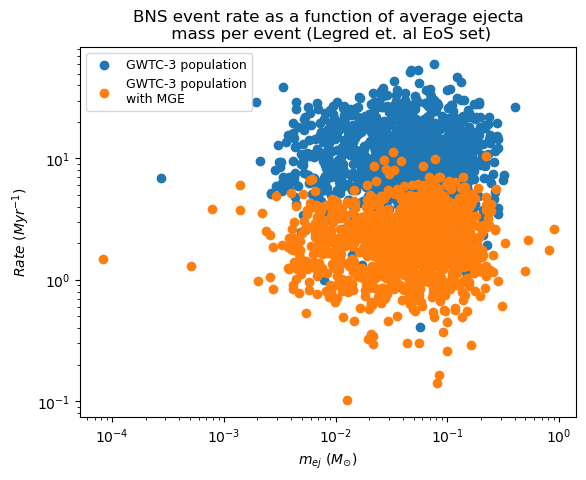

In [18]:
# scatter plot of BNS rate as a function of ejected mass
plt.scatter(M_ej, legred_rates, label = 'GWTC-3 population')
plt.scatter(M_ej_mge, mge_rates, label = 'GWTC-3 population\nwith MGE')
plt.ylabel('$Rate\ (Myr^{-1})$')
plt.xlabel('$m_{ej}\ (M_{\\odot})$')
plt.yscale('log') 
plt.xscale('log')
plt.title('BNS event rate as a function of average ejecta\n mass per event (Legred et. al EoS set)')
plt.legend(loc = 'upper left', fontsize = '9')
plt.show()

In [37]:
from os import listdir
from numpy import argmax
# import CUTER EoS set 
    # because there's a bit over than 50,000 files, executing this cell will take a while
fol_cuter = "Tov_data/set_cuter/tov"
list_tov_file = listdir(fol_cuter)
list_tov_file = [ll for ll in list_tov_file if ".out" in ll]

# make dictionaries of tov mass and radii
tov_m={}
tov_r={}

jj = 0
for tov in range(len(list_tov_file)):
    findname=f"{fol_cuter}/{list_tov_file[jj]}"
    tov_r[jj],tov_m[jj] = np.loadtxt(findname, usecols = (2,3), unpack = True)
    min_mass = tov_m[jj]>=1.0
    tov_r[jj] = tov_r[jj][min_mass]
    tov_m[jj] = tov_m[jj][min_mass]
    try:
        max_ind = argmax(tov_m[jj])
        tov_r[jj] = tov_r[jj][:max_ind] 
        tov_m[jj] = tov_m[jj][:max_ind]
    except ValueError:
        pass
    jj+=1

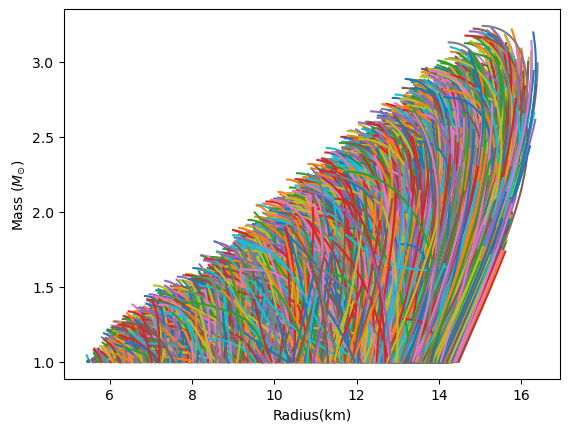

In [38]:
# test plot for EoS set
for i in range(len(list_tov_file)):
    plt.plot(tov_r[i],tov_m[i])
plt.xlabel('Radius(km)')
plt.ylabel('Mass ($M_{\\odot})$')
plt.show()

In [39]:
# obtain ejected mass usinng tov EoS set
tov_M_ej = []
tov_M_ej_mge = []
tov_index = []

for m1, m2, m1_mge, m2_mge in zip(list_mass1, list_mass2, list_mass1_mge, list_mass2_mge):
    # safeguard when interpolating
        # if false will loop over again untill it lands on an EoS that it can interpolate from
    while True:
        try:
            # choose a random Eos    
            key = np.random.choice(range(len(tov_r)))
    
    
            # interpolate the correspodning radius for the objects
            Rad_atM1 = np.interp(m1, tov_m[key], tov_r[key])
            Rad_atM2 = np.interp(m2, tov_m[key], tov_r[key])
    
            # for MGE data
            Rad_atM1_mge = np.interp(m1_mge, tov_m[key], tov_r[key])
            Rad_atM2_mge = np.interp(m2_mge, tov_m[key], tov_r[key])
    
    
            # calculation for the compactness of each object
            Comp_1 = (G * ((m2)*(1.989e30))) / (((Rad_atM2)*(1e3)) * (c**2))
            Comp_2 = (G * ((m1)*(1.989e30))) / (((Rad_atM1)*(1e3)) * (c**2))
    
            # for MGE data
            Comp_1_mge = (G * ((m2_mge)*(1.989e30))) / (((Rad_atM2_mge)*(1e3)) * (c**2))
            Comp_2_mge = (G * ((m1_mge)*(1.989e30))) / (((Rad_atM1_mge)*(1e3)) * (c**2))
    
    
            # calculate disk mass
            M_disk = ((a1*Comp_1) + c1)**d
            
            # for MGE data
            M_disk_mge = ((a1*Comp_1_mge) + c1)**d
    
    
            # making variables for each term in formula of ejected mass for less room of error
            term_1 = a2/Comp_1
            term_2 = b*((m1**n)/(m2**n))
            term_3 = c2*Comp_1
            term2_1 = a2/Comp_2
            term2_2 = b*((m2**n)/(m1**n))
            term2_3 = c2*Comp_2
            
            
            # formula for dynamical mass
            mdyn_form = (((term_1 + term_2 + term_3)*m2) + ((term2_1 + term2_2 + term2_3)*m1))
            Mdyn = mdyn_form * (1e-3)
            
            
            # for MGE data
            term_1_mge = a2/Comp_1_mge
            term_2_mge = b*((m1_mge**n)/(m2_mge**n))
            term_3_mge = c2*Comp_1_mge
            term2_1_mge = a2/Comp_2_mge
            term2_2_mge = b*((m2_mge**n)/(m1_mge**n))
            term2_3_mge = c2*Comp_2_mge
            
            
            # for MGE data
            mdyn_form_mge = (((term_1_mge + term_2_mge + term_3_mge)*m2_mge) + ((term2_1_mge + term2_2_mge + term2_3_mge)*m1_mge))
            Mdyn_mge = mdyn_form_mge * (1e-3)
    
    
            # a_dyn for uncertainty[0.5,1.5] in disk mass
            # f_loss for the uncertainty[0.15,1.0] in the physics of the postmerger remnant
            a_dyn = random.uniform(0.5,1.5)
            f_loss = random.uniform(0.15,1.0)
    
    
            # calculate the ejected mass
            Mej = (a_dyn * Mdyn) + (f_loss * M_disk)
            tov_M_ej.append(Mej)
            
            # for MGE data
            Mej_mge = (a_dyn * Mdyn_mge) + (f_loss * M_disk_mge)
            tov_M_ej_mge.append(Mej_mge)
            
            
            # track the EoS being used
                # not actully necessary
            tov_index.append(key)
            
            break
        except ValueError:
            pass

/tmp/ipykernel_2471711/3375465899.py:34: RuntimeWarning: invalid value encountered in scalar power
  M_disk = ((a1*Comp_1) + c1)**d
/tmp/ipykernel_2471711/3375465899.py:37: RuntimeWarning: invalid value encountered in scalar power
  M_disk_mge = ((a1*Comp_1_mge) + c1)**d


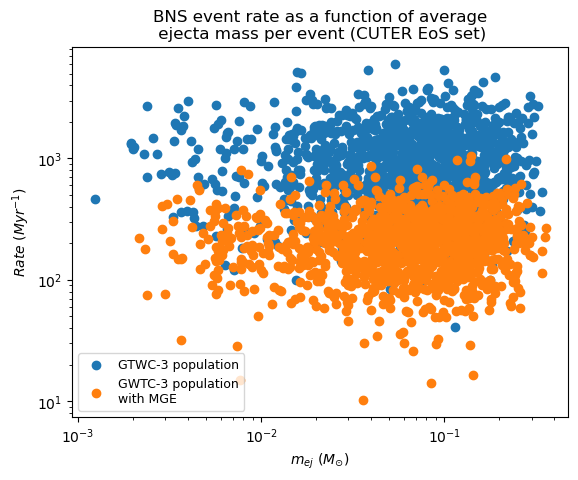

In [40]:
# sactter plot for BNS rate as a function of ejected mass using the CUTER EoS set
plt.scatter(tov_M_ej, rates, label = 'GTWC-3 population')
plt.scatter(tov_M_ej_mge, rates_mge, label = 'GWTC-3 population\nwith MGE')
plt.ylabel('$Rate\ (Myr^{-1})$')
plt.xlabel('$m_{ej}\ (M_{\\odot})$')
plt.yscale('log') 
plt.xscale('log')
plt.title('BNS event rate as a function of average\n ejecta mass per event (CUTER EoS set)')
plt.legend(loc = 'lower left', fontsize = '9')
plt.show()

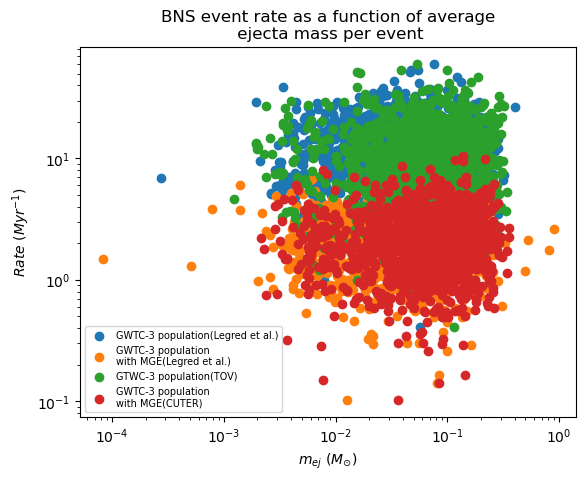

In [41]:
# combined scatter plot for both populations and EoS sets
plt.scatter(M_ej, legred_rates, label = 'GWTC-3 population(Legred et al.)')
plt.scatter(M_ej_mge, mge_rates, label = 'GWTC-3 population\nwith MGE(Legred et al.)')
plt.scatter(tov_M_ej, alt_rates, label = 'GTWC-3 population(TOV)')
plt.scatter(tov_M_ej_mge, alt_rates_mge, label = 'GWTC-3 population\nwith MGE(CUTER)')
plt.ylabel('$Rate\ (Myr^{-1})$')
plt.xlabel('$m_{ej}\ (M_{\\odot})$')
plt.yscale('log') 
plt.xscale('log')
plt.title('BNS event rate as a function of average\n ejecta mass per event')
plt.legend(loc = 'lower left', fontsize = '7')
# plt.savefig("ejected_mass.png")
plt.show()

In [42]:
# because some of the calculated M_ej values ended up being NaN values, keep track of the indices to do the same and exlude corresponding rates
legred_indices = np.where(np.isnan(M_ej))[0]
legred_mge_indices = np.where(np.isnan(M_ej_mge))[0]

In [43]:
# take out NaN values directly out of the M_ej
cleaned_M_ej = [x for x in M_ej if x is not None and not (isinstance(x, float) and math.isnan(x))]
cleaned_M_ej_mge = [x for x in M_ej_mge if x is not None and not (isinstance(x, float) and math.isnan(x))]

In [44]:
# clean up the rates with exluded indices
clean_legred_rates = np.delete(legred_rates, legred_indices)
clean_mge_rates = np.delete(mge_rates, legred_mge_indices)

In [45]:
# verify the lengths
len(cleaned_M_ej), len(clean_legred_rates), len(cleaned_M_ej_mge), len(clean_mge_rates)

(1254, 1254, 1114, 1114)

/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

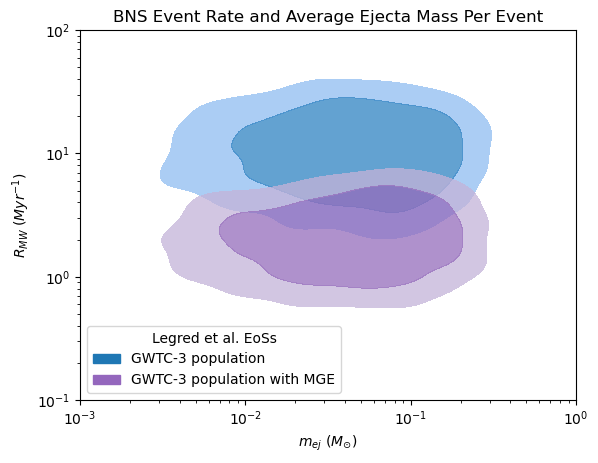

In [55]:
# Create the contour plot using KDE
    # 90% and 68% CI

# Overlay scatter plot (not really needed)
# plt.scatter(x, y, label = 'GWTC-3 population(Legred et al.)')

sns.kdeplot(x = cleaned_M_ej, y = clean_legred_rates, color = 'C0', fill = True, levels = [0.1,0.32,1], log_scale = True, alpha = 0.75)
sns.kdeplot(x = cleaned_M_ej_mge, y = clean_mge_rates, color = 'C4', fill = True, levels = [0.1,0.32,1], log_scale = True, alpha = 0.75)
plt.ylabel('$R_{MW}\ (Myr^{-1})$')
plt.xlabel('$m_{ej}\ (M_{\\odot})$')
plt.yscale('log') 
plt.xscale('log')
plt.xlim(1e-3, 1)
plt.ylim(1e-1, 1e2)
plt.title('BNS Event Rate and Average Ejecta Mass Per Event')
plt.legend(handles = [mpatches.Patch(color='C0', label='GWTC-3 population'),
                      mpatches.Patch(color="C4", label='GWTC-3 population with MGE')],
           loc = 'lower left', fontsize = '10', title = 'Legred et al. EoSs')
# plt.savefig("ejected_mass_legred.png")
plt.show()

/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to N

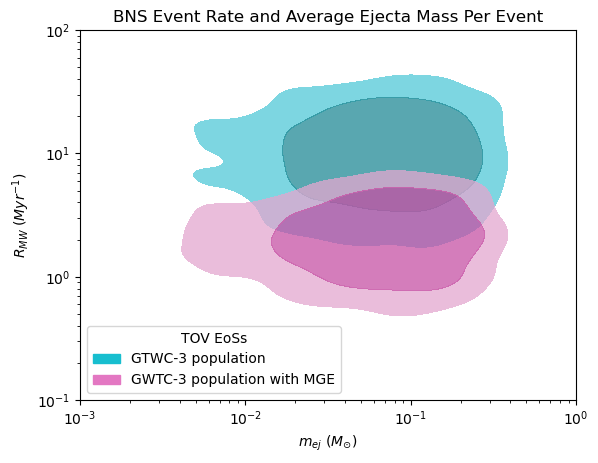

In [56]:
# same but KDE contour plot using the CUTER EoS set
sns.kdeplot(x = tov_M_ej, y = alt_rates,color = 'C9', fill = True, levels = [0.1,0.32,1], log_scale = True, alpha = 0.75)
sns.kdeplot(x = tov_M_ej_mge, y = alt_rates_mge, color = 'C6', fill = True, levels = [0.1,0.32,1], log_scale = True, alpha = 0.75)
plt.ylabel('$R_{MW}\ (Myr^{-1})$')
plt.xlabel('$m_{ej}\ (M_{\\odot})$')
plt.yscale('log') 
plt.xscale('log')
plt.xlim(1e-3, 1)
plt.ylim(1e-1, 1e2)
plt.title('BNS Event Rate and Average Ejecta Mass Per Event')
plt.legend(handles = [mpatches.Patch(color='C9', label='GTWC-3 population'),
                      mpatches.Patch(color="C6", label='GWTC-3 population with MGE')],
           loc = 'lower left', fontsize = '10', title = 'TOV EoSs')
# plt.savefig("ejected_mass_tov.png")
plt.show()